In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gzip
import pickle
import pdb
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace

train_data = datasets.MNIST('/Users/Chris/Downloads',train = True, download= True, transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data = datasets.MNIST('/Users/Chris/Downloads',train = False, download= True, transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

class Sign(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x.clone())
        x[x<0] = -1
        x[x>=0] = 1
        return x
    @staticmethod
    def backward(ctx, grad_output):
      x, = ctx.saved_tensors
      grad_input = grad_output.clone()
      grad_input = grad_input.to(device)
      calculate = (x.abs() < 1.)
      calculate = calculate.type(torch.FloatTensor)
      calculate = calculate.to(device)
      grad_input = calculate * grad_input
      return grad_input
sign = Sign.apply
criterion = nn.CrossEntropyLoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.act = nn.Softmax()
        self.relu = nn.ReLU()

    def forward(self, x):

        Sign()
        x = sign(self.conv1(x))
        x = sign(self.conv2(x))
        x = sign(self.conv3(x))
        x = sign(self.conv4(x))
        x = sign(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        pdb.set_trace()
        x = sign(self.fc1(x))
        x = self.act(self.fc2(x))
        return x
        # Activation function, editable

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.15)
net.zero_grad()
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True)
dataiter = iter(trainloader)
i = 0
j = 0
count = 0
test_accuracy = 0
accuracy_vector = []
test_accuracy_vector = []

for j in range(0,100):
  dataiter = iter(trainloader)
  if test_accuracy > 0.95:
    break
  for batch in dataiter:
    image = batch[0]
    image = image*2 -1
    label = batch[1]
    # Transfer to GPU
    image, label = image.to(device), label.to(device)
    #print(net(local_batch))
    optimizer.zero_grad()
    output = net(image)
    #print(output.argmax(1))
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    i = i+1
    z = output.max(1)
    correct_guesses = z[1] == label
    correct_guesses = correct_guesses.type(torch.FloatTensor)
    accuracy = correct_guesses.mean()
    accuracy_vector.append(accuracy*100)
    count = count + 1
    if count == 25:
      print(test_accuracy)
      testiter = iter(testloader)
      count = 0
      for test_batch in testiter:
        test_image = test_batch[0]
        test_image = test_image*2 -1
        test_label = test_batch[1]
        test_image, test_label = test_image.to(device), test_label.to(device)
        outputtest = net(test_image)
        ztest = outputtest.max(1)
        test_correct_guesses = ztest[1] == test_label
        test_correct_guesses = test_correct_guesses.type(torch.FloatTensor)
        test_accuracy = test_correct_guesses.mean()
        test_accuracy_vector.append(test_accuracy*100)
        break

> <ipython-input-11-12f2cfe6fe40>(64)forward()
-> x = sign(self.fc1(x))
(Pdb) x
tensor([[ 1.,  1., -1.,  ...,  1., -1., -1.],
        [-1.,  1.,  1.,  ..., -1.,  1., -1.],
        [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1.,  1., -1.,  ..., -1., -1.,  1.],
        [-1.,  1.,  1.,  ..., -1.,  1., -1.]],
       device='cuda:0', grad_fn=<ViewBackward>)
(Pdb) x.shape
torch.Size([100, 128])
(Pdb) q


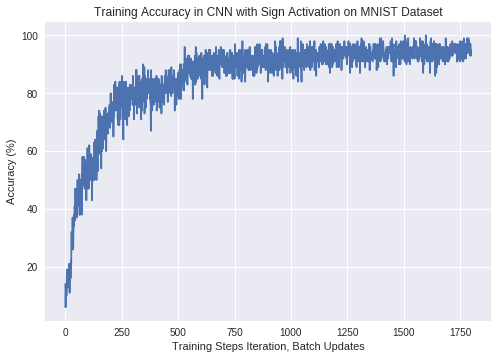

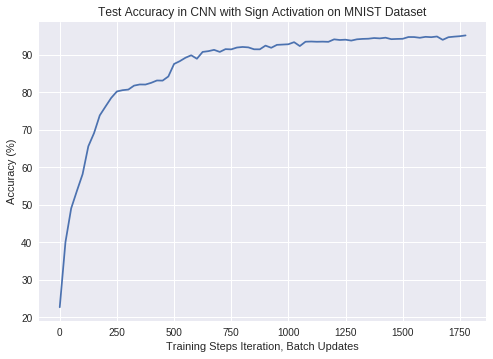

In [10]:
plt.plot(np.arange(len(accuracy_vector)),accuracy_vector)
plt.xlabel('Training Steps Iteration, Batch Updates')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy in CNN with Sign Activation on MNIST Dataset')
plt.show()

plt.plot(25*np.arange(len(test_accuracy_vector)),test_accuracy_vector)
plt.xlabel('Training Steps Iteration, Batch Updates')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy in CNN with Sign Activation on MNIST Dataset')
plt.show()